# LFW Face Database | Part Labels
This notebook shows essentially vanilla-fastai performance on the [LFW | Part Labels Database](http://vis-www.cs.umass.edu/lfw/part_labels/), where we just try to get the algorithm to recognise the head (and hair) in an image.  
I'm going to be taking a less verbose approach in this notebook, if you want more details on image segmentation with fastai, check out [Lesson 3](https://course.fast.ai/videos/?lesson=3).

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

In [6]:
data_path = Path('/home/ubuntu/course-v3/files/face-hair')
img_path = Path(data_path/'images')
lbl_path = Path(data_path/'labels')

# Data munging
I suspect fastai's `SegmentationItemList` expects a 1-layer PNG with the pixels having integeres related to the classes they represent. However, LFW uses `.ppm` files, where 29 is the background color. Because we're only looking to recognise the entire head + hair, we're replacing anything that isn't 29 (the background) with a 1.

In [ ]:
from PIL import Image as pilImage
from os import remove

In [ ]:
raw_mask_path = Path(data_path/'masks')
lbl_path = Path(data_path/'labels')
if not lbl_path.exists():
    lbl_path.mkdir()

In [ ]:
for item in raw_mask_path.glob("**/*.ppm"):
    # Deal with some surprise hidden files
    if not item.name.startswith('.'):
        img = pilImage.open(item)
        img = img.convert('L')
        # Doc says background is 29, so replacing that with 0, anything else with 1
        img = img.split()[0].point(lambda x: 0 if x is 29 else 1)
        img.save(lbl_path/f'{item.stem}.png', transparency=0)

In [ ]:
# Clean up people for whom we have no masks
for item in img_path.glob("**/*.jpg"):
    if Path(lbl_path/f'{item.stem}.png').exists():
        continue
    else:
        os.remove(item)
        print(item)

# Setting up data loader
We now have all our images in `files` and annotations/PNG masks in `annotations`

In [7]:
imgs = get_image_files(img_path, recurse=True)
lbls = get_image_files(lbl_path)
imgs[:3],lbls[:3]

([PosixPath('/home/ubuntu/course-v3/files/face-hair/images/Abdullah_Nasseef/Abdullah_Nasseef_0001.jpg'),
  PosixPath('/home/ubuntu/course-v3/files/face-hair/images/Elodie_Bouchez/Elodie_Bouchez_0001.jpg'),
  PosixPath('/home/ubuntu/course-v3/files/face-hair/images/Leslie_Caldwell/Leslie_Caldwell_0002.jpg')],
 [PosixPath('/home/ubuntu/course-v3/files/face-hair/labels/Russell_Simmons_0003.png'),
  PosixPath('/home/ubuntu/course-v3/files/face-hair/labels/Martha_Beatriz_Roque_0001.png'),
  PosixPath('/home/ubuntu/course-v3/files/face-hair/labels/Valdas_Adamkus_0002.png')])

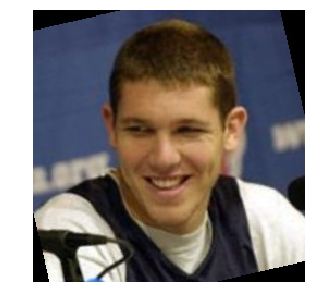

In [8]:
example_image = imgs[6]
img = open_image(example_image)
img.show(figsize=(5,5))

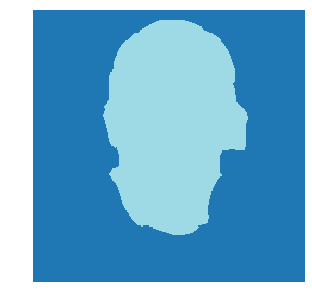

In [9]:
mask = open_mask(lbl_path/f'{example_image.stem}.png')
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data 

(array([250, 250]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [11]:
# Yikes this stuff is GPU RAM hungry
size = src_size
bs = 16
size

array([250, 250])

In [12]:
def get_y_fname(x):
    return lbl_path/f'{x.stem}.png'

In [13]:
codes = np.array(['background', 'face'], dtype=str)

In [14]:
src = (SegmentationItemList.from_folder(img_path, recurse=True)
      .split_by_rand_pct(0.2, 42)
       .label_from_func(get_y_fname, classes=codes)
      )

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

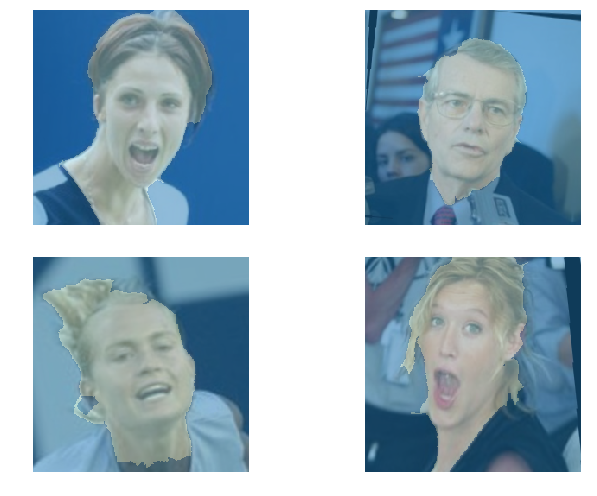

In [16]:
data.show_batch(2, figsize=(10,7))

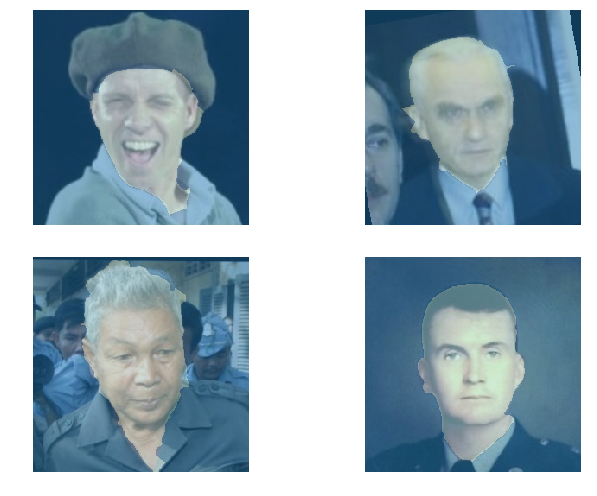

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

Using the CamVid accuracy metric as shown in the fastai course for pixel-level accuracy measuring. Might be worth at a later stage to experiment with other ones though.

In [13]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [14]:
metrics=acc_camvid

In [15]:
wd=1e-2

# First training
Some initial training, small file sizes, frozen models, with a pretrained resnet34.

In [16]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


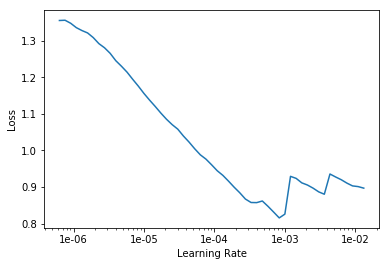

In [17]:
lr_find(learn)
learn.recorder.plot()

In [18]:
!curl -X POST https://maker.ifttt.com/trigger/jupyter_done/with/key/{redacted}

Congratulations! You've fired the jupyter_done event

In [19]:
lr = 3e-5

## First frozen training

In [20]:
learn.fit_one_cycle(4, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.453319,0.220781,0.912419,04:34
1,0.181867,0.135670,0.945133,04:25
2,0.131748,0.099740,0.960818,04:25
3,0.108430,0.087317,0.965941,04:26


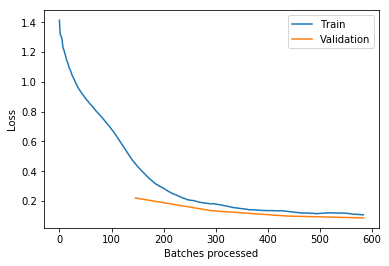

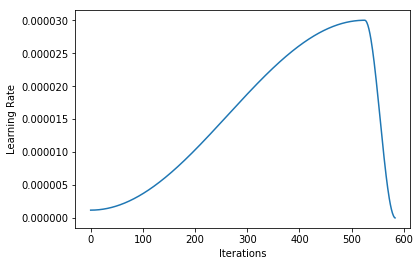

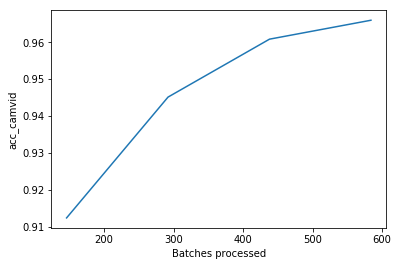

In [21]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()
learn.recorder.plot_metrics()

Congratulations! You've fired the jupyter_done event

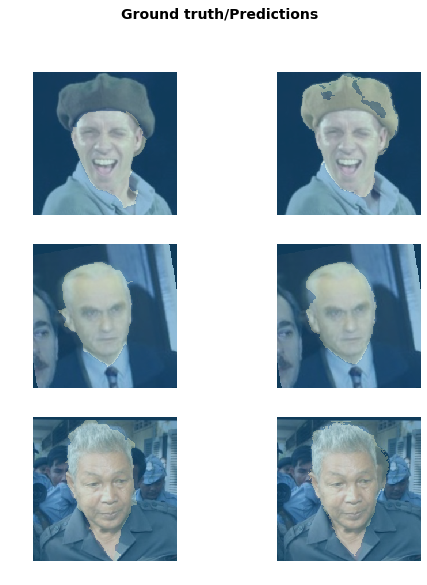

In [22]:
learn.show_results(rows=3, figsize=(8,9))
!curl -X POST https://maker.ifttt.com/trigger/jupyter_done/with/key/{redacted}

So I mean, that looks halfway decent, some of the easy things it got right, but there's still some training to be done here.

In [ ]:
learn.save('stage-1')
learn.load('stage-1')

## Unfreezing stage 1

In [25]:
learn.load('stage-1')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


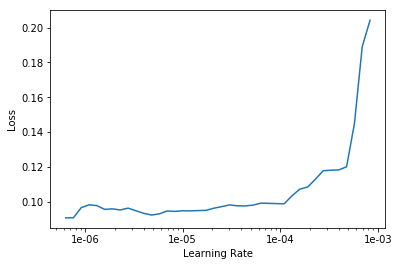

In [26]:
lr_find(learn)
learn.recorder.plot()

In [35]:
!curl -X POST https://maker.ifttt.com/trigger/jupyter_done/with/key/{redacted}

Congratulations! You've fired the jupyter_done event

In [28]:
lr = 3e-6

In [29]:
learn.fit_one_cycle(4, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.093434,0.085409,0.966821,04:35
1,0.093037,0.084498,0.967056,04:36
2,0.090196,0.082133,0.968030,04:36
3,0.090807,0.081106,0.968527,04:36


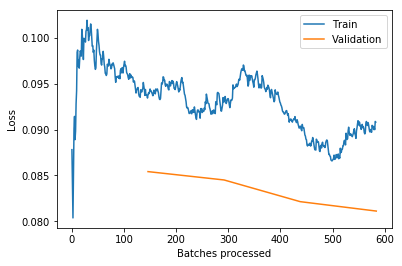

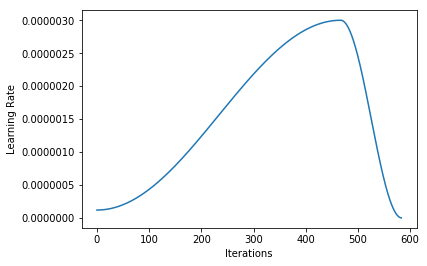

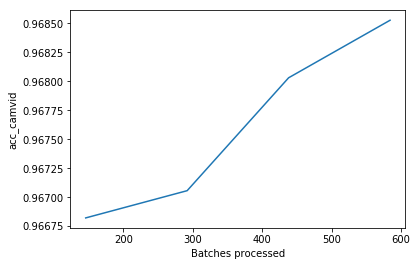

In [30]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()
learn.recorder.plot_metrics()

Congratulations! You've fired the jupyter_done event

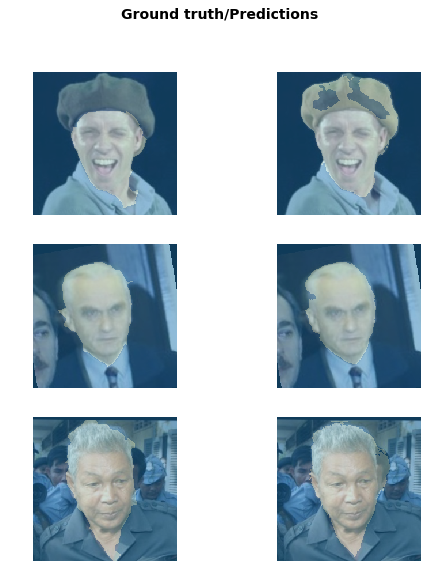

In [31]:
learn.show_results(rows=3, figsize=(8,9))
!curl -X POST https://maker.ifttt.com/trigger/jupyter_done/with/key/{redacted}

Ehh, it's learning something, we can still do better. That's a hell of a spiky loss though. Seems to do better when pct is higher.

In [ ]:
learn.save('stage-1-unfrozen')
learn.load('stage-1-unfrozen')

# Stage 2 training

In [33]:
learn.load('stage-1-unfrozen')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


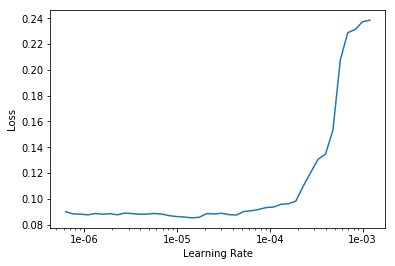

In [34]:
lr_find(learn)
learn.recorder.plot()

In [36]:
lr = 1e-6

In [37]:
learn.fit_one_cycle(4, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.087186,0.080849,0.968588,04:35
1,0.086262,0.081996,0.968299,04:35
2,0.085664,0.080544,0.968738,04:36
3,0.085888,0.080060,0.968905,04:36


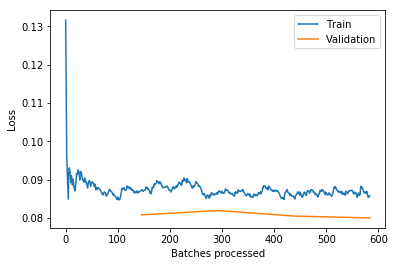

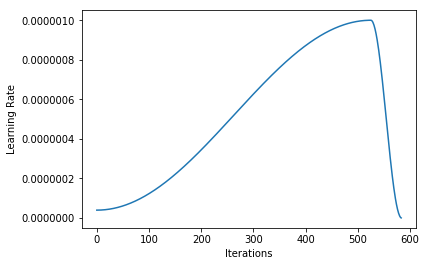

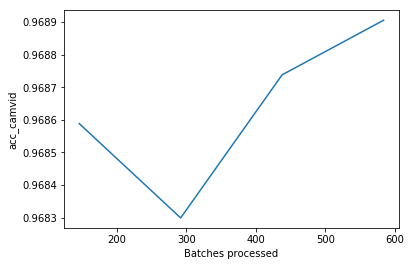

In [38]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()
learn.recorder.plot_metrics()

Looks like the validation loss essentially flatlined, I'm not sure I'll be able to get much more out of it. Let's see how the algorithm goes.

Congratulations! You've fired the jupyter_done event

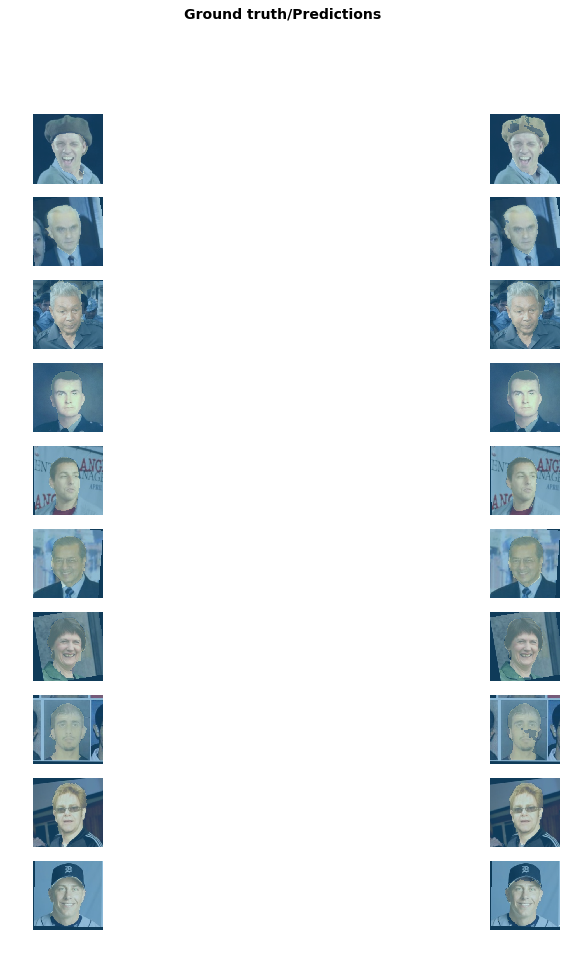

In [41]:
learn.show_results(rows=10, figsize=(15,15))
!curl -X POST https://maker.ifttt.com/trigger/jupyter_done/with/key/{redacted}

Keeping the quality of the segmentation in mind (which wasn't fantastic), the algorithm does decently well. Clearly it picks up on the structure of the head and hair. However, it clearly struggles with textures and darkbackgrounds, which is generally a weakness, as can be seen in the first image or the 3rd-to-last one. 

In [43]:
learn.export('./models/export.pkl')